In [7]:
# import numpy and pandas, and DataFrame / Series
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
# Set some pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
# And some items for matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import sys


from finances import *
from finances.categories import *


In [4]:
def backend(folder):
    return FilesystemBackend( folder )

ac = Account( backend("./ws/") )
m = ac.month( "mar", 2018 )

def get_records( iter_, fn = lambda _: True ):
    return [ t for t in iter_ if fn(t) ]

def total( iter_ ):
    return float(sum( t.value for t in iter_ ))

def filter_(r):
    return r.is_groceries


records_per_week = [ get_records(w.records(), filter_) for w in m.weeks() ]

total_week = [ list(records) for records in records_per_week ]

total_week


[[50.0, groceries, groceries],
 [40.0, groceries, groceries, 100.0, groceries, groceries],
 [],
 [],
 []]

In [10]:
class PieSection:
    
    def __init__( self, label, fn ):
        self.label = label
        self.fn = fn
        self.transactions = []
        self.next = None
        
    def add( self, transaction ):
        if self.fn(transaction):
            self.transactions.append(transaction)
            return
            
        if self.next is not None:
            self.next.add(transaction)
            
    def printLL(self):
        print(self.label + str([ (t.value, t.categories[0].__class__.__name__) for t in self.transactions ]))
        if(self.next):
            self.next.printLL()
            
def section( label, fn = None ):
    if fn is None:
        fn = lambda t: t.is_of_category(categories.get_category(label))
        
    return PieSection( label, fn )

def anything_else( label = "Anything else" ):
    return PieSection(label, lambda _: True)

def transaction_list(trans_list):
    for t in trans_list:
        yield parse_transaction(t)


class PieChart:    
    def __init__(self, sections):
        self.sections = sections
        self._make_linked_list()
        self._head = sections[0]
        
    def add_transaction(self,trans):
        self._head.add(trans)
        
    def _make_linked_list(self):
        sections = self.sections
        sect = sections[0]
        
        for s in sections[1:]:
            sect.next = s
            sect = s
            
    def as_data_frame(self):
        labels = [ sc.label for sc in self.sections ]
        values = [ total(sc.transactions) for sc in self.sections]
        return pd.DataFrame({ "values": values, "labels": labels} , index = labels)

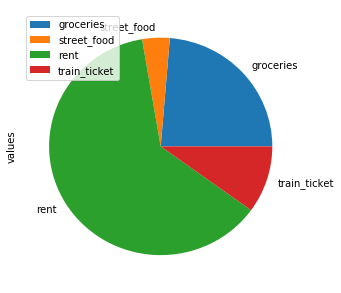

In [13]:
pc = PieChart([
    section("groceries"),
    section("street_food"),
    section("rent"),
    section("train_ticket")
])

for t in ac.month( "mar", 2018 ).records():
    pc.add_transaction(t)

df = pc.as_data_frame()
plot = df.plot.pie(y='values', figsize=(5, 5))

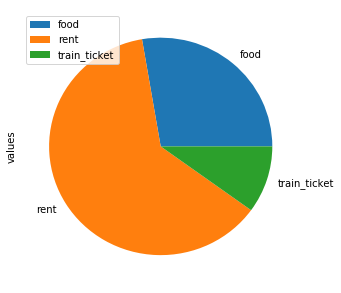

In [15]:
pc = PieChart([
    section("food", lambda r: r.is_food or r._is_groceries),
    section("rent"),
    section("train_ticket")
])

for t in ac.month( "mar", 2018 ).records():
    pc.add_transaction(t)

df = pc.as_data_frame()
plot = df.plot.pie(y='values', figsize=(5, 5))